TODO before:

    Make sure both are optimised while using the same Best Estimate values of the static uncertainty
    Use those same Best Estimate values for here.

In [1]:
import pickle
import numpy as np
import pandas as pd

from geopy.distance import great_circle

import pygmo as pg

In [2]:
from lib.fl_model_v9 import *

# Load Optimised Policies 

In [3]:
case = "Nepal"

## Load all policies proposed by perfect info

In [4]:
# # Store data (serialize)
# with open('{}/MOO/rob_nondom_pols_test1.pickle'.format(case),
#           'wb') as handle:
#     pickle.dump(
#         (rob_nondom_pols),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)
    
with open('{}/MOO/rob_nondom_pols_test3_norobustnessfilter.pickle'.format(case),
          'rb') as handle:
    Full_Info_nondom_pols = pickle.load(
        handle)

In [5]:
Full_Info_nondom_pols.shape

(72,)

## Load all policies proposed by dynamic uncertainty

In [6]:
output_folder = "infov3_4p"

In [7]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [17]:
p4_labels = global_label_tree['p4']

In [18]:
[global_policy_tree[p4_labels[0]]]

[{'FLO0': 0.0,
  'FLO1': 0.0,
  'FLO2': 0.0,
  'FLO3': 1.0,
  'FLO4': 1.0,
  'FLO5': 0.0,
  'FLO6': 0.0,
  'FLO7': 1.0,
  'FLO8': 0.0,
  'FLO9': 0.0,
  'FLO10': 0.0,
  'FLO11': 1.0,
  'FLO12': 0.0,
  'FLO13': 0.0,
  'FLO14': 0.0,
  'FLO15': 0.0,
  'FLO16': 0.0,
  'FLO17': 0.0,
  'FLO18': 0.0,
  'FLO19': 0.0}]

In [19]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [20]:
p4_pols = np.array(p4_pols)

In [21]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format((p4_pols.shape)))

P4 after Multi-Period Robust Optimisation contains (1351,) number of policies


In [22]:
p4_FLs = np.array([[int(key[3:]) for key,value in pol.items() if value == 1] for pol in p4_pols])

# Compare on best estimate performance

## Set parameters of best estimates. Should be the same as used for 

In [23]:
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)

DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns

# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}


In [24]:
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_opening_costs,50.0,100,200
unit_transport_cost,0.5,1,2
FL_operations_cost,20.0,30,50
FL_range,2.0,4,6
demand_per_affected,10.0,20,50


In [25]:
print("Pick right Epicentre, or load disruption data")
print("TODO: Load disruption")

Pick right Epicentre, or load disruption data
TODO: Load disruption


In [26]:
epicentre_name = "RealLocation"

In [27]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [28]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

## Evaluate PerfectInfoPols under best estimates of static uncertainty

In [30]:
Full_Info_nondom_pols.shape

(72,)

In [31]:
perfect_info_best_est_results = []
for pol in Full_Info_nondom_pols:
    perfect_info_best_est_results.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **pol,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [32]:
perfect_info_best_est_results = np.array(perfect_info_best_est_results)

## Evaluate DynamicUncPols under best estimates of static uncertainty

In [34]:
len(p4_pols)

1351

In [36]:
Dyn_Unc_best_est_results = []
for pol in p4_pols:
    Dyn_Unc_best_est_results.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **pol,
            **DSRDP,
            **DSRFL,
            **DPpop))

# Compare distributions

In [40]:
perfect_info_best_est_results.shape

(72, 6)

In [42]:
Dyn_Unc_best_est_results = np.array(Dyn_Unc_best_est_results)

In [43]:
Dyn_Unc_best_est_results.shape

(1351, 6)

In [44]:
Dyn_Unc_best_est_results[:,0]

array([118502.43098280455, 121687.22201560512, 272084.4154191506, ...,
       230370.18915833393, 65253.881256298904, 47386.75661875982],
      dtype=object)

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

<b>TODO: Not Right Yet: Should be in perspective!! </b>

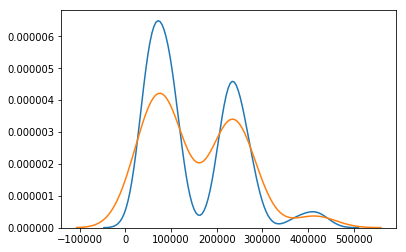

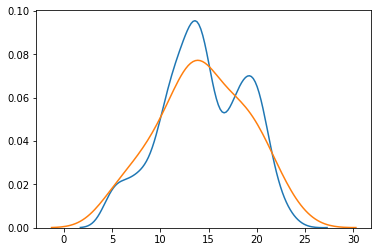

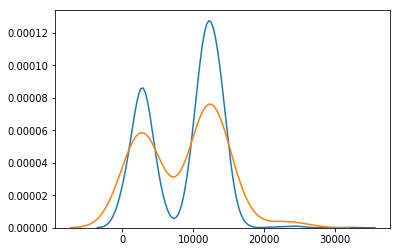

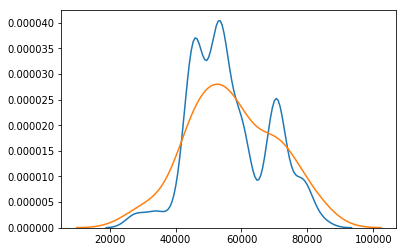

In [97]:
for i in range(4):
    sns.kdeplot(Dyn_Unc_best_est_results[:,i], )
    sns.kdeplot(perfect_info_best_est_results[:,i],)
    plt.show()

In [86]:
perfect_info_best_est_results[:,0].min()

26690.850496369712

In [84]:
len(Dyn_Unc_best_est_results[:,0])

1351

C:\Users\timro\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


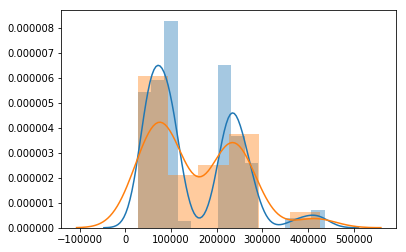

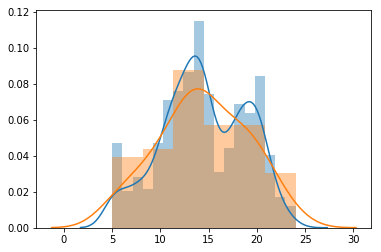

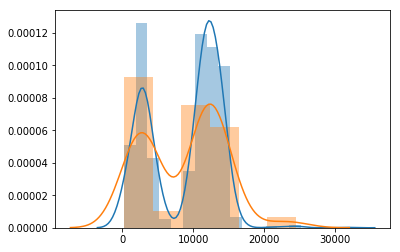

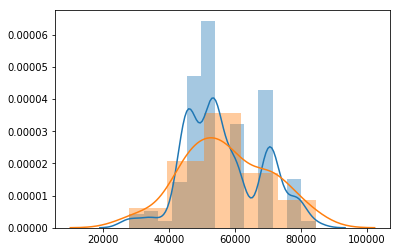

In [127]:
for i in range(4):
    sns.distplot(np.array(list(Dyn_Unc_best_est_results[:,i])), )
    sns.distplot(np.array(list(perfect_info_best_est_results[:,i])),)
    plt.show()

C:\Users\timro\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


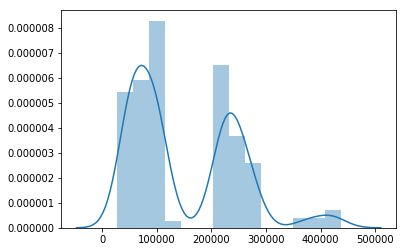

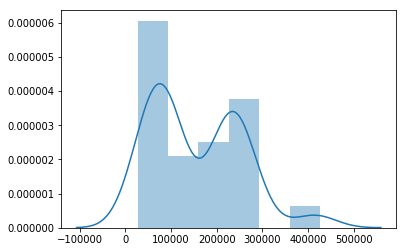

In [130]:
sns.distplot(np.array(list(Dyn_Unc_best_est_results[:,0])), )
plt.show()
sns.distplot(np.array(list(perfect_info_best_est_results[:,0])),)
plt.show()